In [181]:
!pip install -U scikit-learn imblearn
!pip install phik
!pip install tqdm
!pip install imblearn
!pip install catboost


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import (train_test_split,
                                    GridSearchCV,
                                    cross_val_score)
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder,
                                   StandardScaler)
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (f1_score,
                            roc_auc_score,
                            precision_score,
                            recall_score,
                            roc_curve,
                            auc)

pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings('ignore')

import phik

from tqdm import tqdm_notebook

from imblearn.over_sampling import SMOTE

from collections import Counter

from catboost import (CatBoost,
                      CatBoostClassifier,
                      Pool, 
                      cv)

In [182]:
df = pd.read_csv('/datasets/Churn.csv')

In [183]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [185]:
data = df

In [186]:
df.columns = df.columns.str.replace(r'(?<!^)([A-Z])', r'_\1')
df.columns = df.columns.str.lower()
df = df.applymap(lambda x: x.lower() if type(x) == str else x)

In [187]:
df = df.drop(['surname','row_number','customer_id'], axis=1)

In [188]:
encoder = OneHotEncoder()
columns_to_encode = ['gender', 'geography']
encoded_columns = encoder.fit_transform(df[columns_to_encode])
categories = encoder.categories_
feature_names = []
for i, column in enumerate(columns_to_encode):
    for category in categories[i]:
        feature_names.append(column + '_' + str(category))
df = pd.concat([df.drop(columns_to_encode, axis=1),
                        pd.DataFrame(encoded_columns.toarray(), 
                                     columns=feature_names)], axis=1)

In [189]:
mask = df.isnull().any(axis=1)
df[mask].head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,gender_female,gender_male,geography_france,geography_germany,geography_spain
30,591,39,NaN,0.00,3,1,0,140469.38,1,1.0,0.0,0.0,0.0,1.0
48,550,38,NaN,103391.38,1,0,1,90878.13,0,0.0,1.0,0.0,1.0,0.0
51,585,36,NaN,146050.97,2,0,0,86424.57,0,0.0,1.0,0.0,1.0,0.0
53,655,41,NaN,125561.97,1,0,0,164040.94,1,0.0,1.0,0.0,1.0,0.0
60,742,35,NaN,136857.00,1,0,0,84509.57,0,0.0,1.0,0.0,1.0,0.0


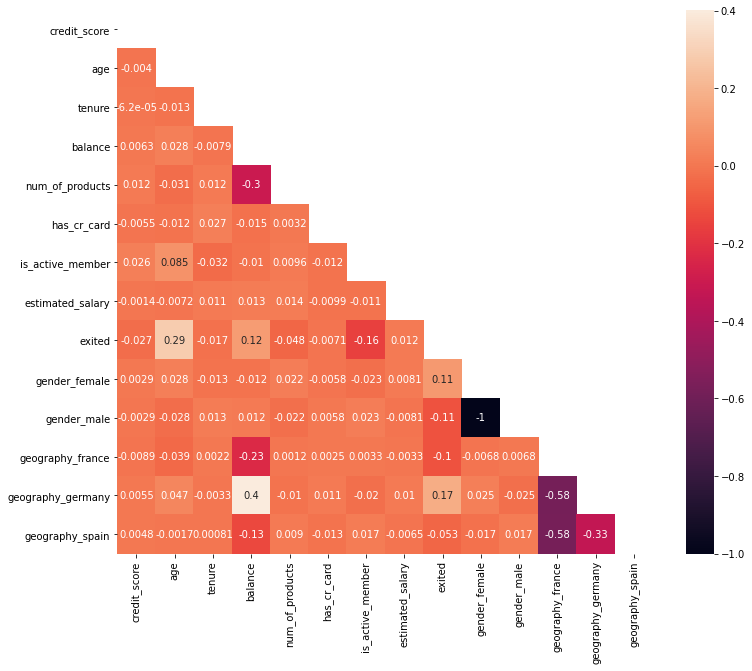

In [190]:
#посмотрим на взаимосвязь с целевой переменной 
mask = np.zeros_like(df.corr().round())
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, ax=ax, mask=mask);

In [191]:
phik_overview = df.phik_matrix()
phik_overview['exited'].sort_values(ascending=False)

interval columns not set, guessing: ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited', 'gender_female', 'gender_male', 'geography_france', 'geography_germany', 'geography_spain']


exited               1.000000
num_of_products      0.565084
age                  0.487524
geography_germany    0.268297
is_active_member     0.241939
balance              0.183365
gender_female        0.165422
gender_male          0.165422
geography_france     0.163000
credit_score         0.096525
geography_spain      0.080682
tenure               0.020845
has_cr_card          0.000000
estimated_salary     0.000000
Name: exited, dtype: float64

In [192]:
#обработаем пропуски
df['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

In [193]:
df['tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64

In [194]:
#df['tenure'][np.isnan(df['tenure'])] = np.random.randint(1, 11, size=np.isnan(df['tenure']).sum())
df['tenure'] = df['tenure'].fillna(df['tenure'].median())

In [195]:
df['tenure'].describe()

count    10000.00000
mean         4.99790
std          2.76001
min          0.00000
25%          3.00000
50%          5.00000
75%          7.00000
max         10.00000
Name: tenure, dtype: float64

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             10000 non-null  float64
 3   balance            10000 non-null  float64
 4   num_of_products    10000 non-null  int64  
 5   has_cr_card        10000 non-null  int64  
 6   is_active_member   10000 non-null  int64  
 7   estimated_salary   10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   gender_female      10000 non-null  float64
 10  gender_male        10000 non-null  float64
 11  geography_france   10000 non-null  float64
 12  geography_germany  10000 non-null  float64
 13  geography_spain    10000 non-null  float64
dtypes: float64(8), int64(6)
memory usage: 1.1 MB


In [197]:
RANDOM_STATE = 42

In [198]:
#разобьем на тренировочную и тестовую выборки
target = df['exited']
features = df.drop('exited', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=RANDOM_STATE)

X_test, X_valid, y_test, y_valid = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=RANDOM_STATE)

In [199]:
# стандартизация данных

numeric = df.drop('exited', axis=1).columns

scaler = StandardScaler()
scaler.fit(df[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric]) 
X_test[numeric] = scaler.transform(X_test[numeric]) 

In [200]:
features_train.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,gender_female,gender_male,geography_france,geography_germany,geography_spain
9761,1.618972,2.009882,0.000761,-0.056693,0.807737,0.646092,0.970243,-1.438677,1.095988,-1.095988,-1.002804,1.727904,-0.573809
3159,1.898335,-1.518201,-0.361575,0.877787,-0.911583,0.646092,-1.030670,-1.389224,-0.912419,0.912419,0.997204,-0.578736,-0.573809
1489,-0.429689,0.007457,1.087768,1.044797,-0.911583,-1.547768,0.970243,1.314157,1.095988,-1.095988,0.997204,-0.578736,-0.573809
2987,0.263545,-1.232140,-1.448581,0.510668,-0.911583,-1.547768,-1.030670,-0.693099,1.095988,-1.095988,-1.002804,1.727904,-0.573809
812,-1.391939,-0.564665,-0.723910,-1.225848,0.807737,0.646092,0.970243,-0.719985,1.095988,-1.095988,-1.002804,-0.578736,1.742740


In [201]:
X_valid.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,gender_female,gender_male,geography_france,geography_germany,geography_spain
7072,0.367013,-0.183251,1.450103,0.930770,-0.911583,0.646092,-1.030670,-1.260596,-0.912419,0.912419,0.997204,-0.578736,-0.573809
6204,-1.578181,-0.564665,-1.448581,1.949345,-0.911583,0.646092,-1.030670,-0.529076,-0.912419,0.912419,0.997204,-0.578736,-0.573809
7110,0.294585,-1.041433,1.450103,-1.225848,0.807737,-1.547768,0.970243,-0.666494,1.095988,-1.095988,-1.002804,-0.578736,1.742740
220,0.780884,-0.755372,1.450103,0.612815,0.807737,0.646092,0.970243,-0.033242,1.095988,-1.095988,0.997204,-0.578736,-0.573809
69,0.253198,-1.708908,1.087768,0.350791,-0.911583,0.646092,-1.030670,-1.423937,1.095988,-1.095988,0.997204,-0.578736,-0.573809


In [202]:
X_test.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,gender_female,gender_male,geography_france,geography_germany,geography_spain
8113,-2.374883,-0.469311,0.363096,0.228185,-0.911583,0.646092,0.970243,-1.528971,-0.912419,0.912419,-1.002804,-0.578736,1.742740
1562,0.449787,-0.755372,0.363096,0.521950,0.807737,0.646092,0.970243,-1.402272,-0.912419,0.912419,-1.002804,1.727904,-0.573809
5735,-0.678012,0.484225,-0.361575,-1.225848,0.807737,-1.547768,0.970243,0.028487,1.095988,-1.095988,-1.002804,-0.578736,1.742740
9834,-1.391939,0.674932,0.363096,-0.228765,-0.911583,-1.547768,0.970243,1.244907,1.095988,-1.095988,0.997204,-0.578736,-0.573809
5379,-0.243447,-1.708908,0.725432,0.360724,-0.911583,0.646092,0.970243,1.200996,1.095988,-1.095988,0.997204,-0.578736,-0.573809


### Результаты подготовки данных


- Все слова приведены к нижнему регистру, между словами проставлены нижние подчеркивания


- Удален столбец с фамилиями т.к. для исследования нам данный столбец не нужен т.к. является категориальной фичей, а идентифицировать пользователя нам легче по customer_id


- Категориальные признаки по месту нахождения и гендерной принадлежности были переведены в количественные.


- Phik корреляция указала на то что столбцы num_of_products и age имееют большую влияние на целевую переменную.


- Пропуски tenure - значения в столбце приблизительно равнораспределены, сначала я хотел сделать модель регрессии которая бы предсказала мне значения столбца, но обе корреляции указывают на то что данный столбец имеет наименьшую ценность для целевой переменной. Потом решил заполнить значения - случайными числами от 1-10, но понял что это неправильно. В итоге заполнил средним т.к. нет выбросов и признак достаточно равнораспределен, возможно вообще удалю весь столбец.


- Выборки разбиты на тренировочную и валидационную


- Проведена стандартизация всех переменных

## Исследование задачи

0    7963
1    2037
Name: exited, dtype: int64


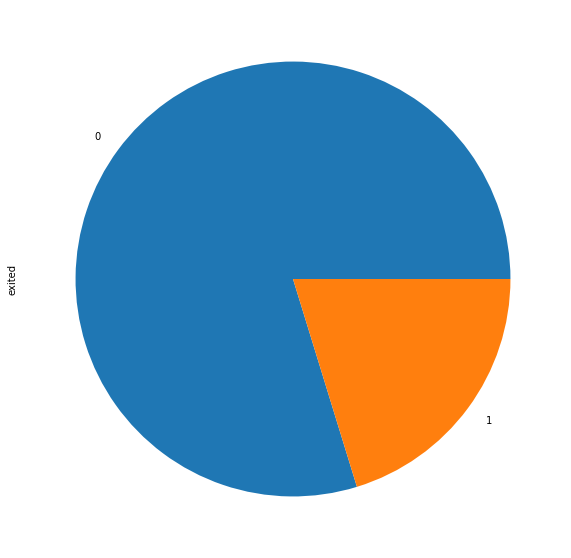

In [203]:
print(df['exited'].value_counts())
target_valid.value_counts().plot(kind='pie', 
                                 y='exited',
                                 figsize = (10,10),
                                 );

clf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 10],
    'max_depth': [10, 35, 2],
    'min_samples_leaf': range (1,5),
    'min_samples_split': range (1,10)}
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1', verbose=10)  
grid_search.fit(features_train, target_train)

print('Наилучшая комбинация параметров:', grid_search.best_params_)
print('f1 score =', grid_search.best_score_)

Наилучшая комбинация параметров: {'max_depth': 35, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 200}


f1 score = 0.5595536439820081

**Перевел в markdown т.к. долго выполняется**

In [204]:
def calculate_metrics(model, X, y):
    y_pred = model.predict(X)
    f1 = f1_score(y_pred, y)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    probabilities_valid = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, probabilities_valid)
    roc_auc_curve = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_curve)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC_AUC')
    plt.legend(loc="lower right")
    plt.show()

    return print(f"f1_score = {f1}\nroc_auc = {roc_auc_curve}\nprecision = {precision}\nrecall = {recall}")

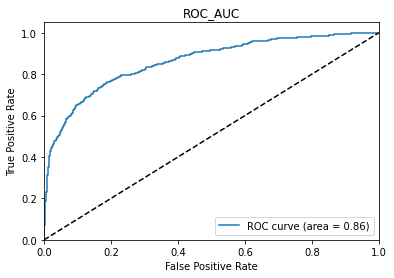

f1_score = 0.5961820851688693
roc_auc = 0.8608413568360243
precision = 0.8087649402390438
recall = 0.4720930232558139


In [205]:
param_rf = {
    'n_estimators': 200,
    'max_depth': 35,
    'min_samples_leaf': 1,
    'min_samples_split': 7
}

model_rf = RandomForestClassifier(random_state=RANDOM_STATE, **param_rf)
model_rf.fit(features_train, target_train)
calculate_metrics(model_rf, X_valid, y_valid)

### Результат исследования задачи


- Выявлен дисбаланс классов - строк с 1 классом в 4 раза меньше, чем строк с классом 0


- С помощью gridsearch были определены лучшие гиперпараметры для модели случайного леса


- Написана функция для подсчета метрик


- Результат f1 на алгоритме случайного леса с Hold-out валидацией и найденными параметрами на gridsearch 0.5873417721518988 что я считаю неплохим результатом


- Результат f1 на алгоритме случайного леса с Cross валидацией и найденными параметрами на gridsearch 0.5708888036152067 при наличии выброса 0.46071429 который сильно отражается на средней:(

## Борьба с дисбалансом

- Убедимся в том что выборки которые мы будем балансить содержат только обучающие данные (0.6 от всего датасета)

In [229]:
len(target_train)

6000

In [230]:
features_train

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,gender_female,gender_male,geography_france,geography_germany,geography_spain
9761,1.618972,2.009882,0.000761,-0.056693,0.807737,0.646092,0.970243,-1.438677,1.095988,-1.095988,-1.002804,1.727904,-0.573809
3159,1.898335,-1.518201,-0.361575,0.877787,-0.911583,0.646092,-1.030670,-1.389224,-0.912419,0.912419,0.997204,-0.578736,-0.573809
1489,-0.429689,0.007457,1.087768,1.044797,-0.911583,-1.547768,0.970243,1.314157,1.095988,-1.095988,0.997204,-0.578736,-0.573809
2987,0.263545,-1.232140,-1.448581,0.510668,-0.911583,-1.547768,-1.030670,-0.693099,1.095988,-1.095988,-1.002804,1.727904,-0.573809
812,-1.391939,-0.564665,-0.723910,-1.225848,0.807737,0.646092,0.970243,-0.719985,1.095988,-1.095988,-1.002804,-0.578736,1.742740
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,1.215448,1.437761,1.087768,-0.108554,-0.911583,0.646092,0.970243,-0.534002,-0.912419,0.912419,0.997204,-0.578736,-0.573809
5191,0.325625,1.819175,-1.448581,-1.225848,-0.911583,0.646092,0.970243,-1.728184,1.095988,-1.095988,0.997204,-0.578736,-0.573809
5390,0.874005,-0.087897,-1.448581,-1.225848,2.527057,-1.547768,-1.030670,-0.136854,1.095988,-1.095988,0.997204,-0.578736,-0.573809
860,0.170424,0.388871,1.087768,1.822949,-0.911583,0.646092,-1.030670,-0.044902,-0.912419,0.912419,0.997204,-0.578736,-0.573809


### SMOTE

In [231]:
sm = SMOTE(sampling_strategy= 1, random_state=RANDOM_STATE)
X_res, y_res = sm.fit_resample(features_train, target_train)
print('Resampled dataset shape %s' % Counter(y_res))

data = np.column_stack((X_res, y_res))
data_shuffled = shuffle(data, random_state=RANDOM_STATE)
X_res = data_shuffled[:, :-1]
y_res = data_shuffled[:, -1]
X_res = pd.DataFrame(X_res, columns=features_train.columns)

Resampled dataset shape Counter({0: 4773, 1: 4773})


In [232]:
y_valid.value_counts()

0    1570
1     430
Name: exited, dtype: int64

### CATBOOST sm

#Catboost
cat_model = CatBoostClassifier()
cat_grid = {'learning_rate': [0.03, 0.1],
            'depth': [4, 6],
            'l2_leaf_reg': [1, 5]
           }
grid_search = GridSearchCV(cat_model, cat_grid, cv=5,scoring='f1')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

In [233]:
X_res

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,gender_female,gender_male,geography_france,geography_germany,geography_spain
0,0.877997,1.675576,1.480658,1.084825,-0.911583,-1.547768,-1.030670,0.832076,1.095988,-1.095988,-1.002804,1.727904,-0.573809
1,-0.581757,1.349123,-0.359023,-1.225848,-0.911583,0.646092,-1.030670,-1.643639,1.095988,-1.095988,0.997204,-0.578736,-0.573809
2,-1.205697,-0.469311,0.000761,0.722273,0.807737,0.646092,0.970243,-0.520127,1.095988,-1.095988,0.997204,-0.578736,-0.573809
3,0.288560,0.443125,-0.697364,0.858956,-0.911583,-1.547768,0.970243,-1.255799,1.095988,-1.095988,-1.002804,1.727904,-0.573809
4,-1.185004,0.484225,-0.361575,0.727838,-0.911583,-1.547768,-1.030670,0.537615,1.095988,-1.095988,-1.002804,1.727904,-0.573809
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9541,-2.519738,-0.183251,-1.448581,-1.225848,-0.911583,0.646092,0.970243,-0.885607,-0.912419,0.912419,-1.002804,-0.578736,1.742740
9542,0.367013,-0.087897,0.363096,1.166022,-0.911583,0.646092,0.970243,-0.039386,-0.912419,0.912419,0.997204,-0.578736,-0.573809
9543,-1.909278,0.770285,0.000761,0.410291,-0.911583,0.646092,0.970243,1.451043,1.095988,-1.095988,-1.002804,1.727904,-0.573809
9544,0.687763,-0.373958,-1.448581,-1.225848,2.527057,-1.547768,-1.030670,1.298609,-0.912419,0.912419,-1.002804,-0.578736,1.742740


In [234]:
train_data = Pool(data=X_res,
                  label=y_res
                 )

valid_data = Pool(data=X_valid,
                  label=y_valid
                 )

In [235]:
cat_model_smote = CatBoostClassifier(verbose=100,learning_rate = 0.004
                               , random_state=RANDOM_STATE,eval_metric='TotalF1')
cat_model_smote.fit(train_data, eval_set = valid_data,use_best_model=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7772262	test: 0.8114192	best: 0.8114192 (0)	total: 5.81ms	remaining: 5.81s
100:	learn: 0.8028405	test: 0.8123347	best: 0.8176386 (2)	total: 491ms	remaining: 4.37s
200:	learn: 0.8104915	test: 0.8158510	best: 0.8176386 (2)	total: 1s	remaining: 3.98s
300:	learn: 0.8211798	test: 0.8194615	best: 0.8194615 (296)	total: 1.49s	remaining: 3.46s
400:	learn: 0.8274609	test: 0.8284202	best: 0.8292825 (377)	total: 2.01s	remaining: 3s
500:	learn: 0.8359494	test: 0.8313501	best: 0.8314396 (491)	total: 2.54s	remaining: 2.53s
600:	learn: 0.8438051	test: 0.8363516	best: 0.8363516 (597)	total: 3.09s	remaining: 2.05s
700:	learn: 0.8485170	test: 0.8385150	best: 0.8385150 (666)	total: 3.56s	remaining: 1.52s
800:	learn: 0.8550105	test: 0.8411705	best: 0.8414547 (743)	total: 4.16s	remaining: 1.03s
900:	learn: 0.8606684	test: 0.8417466	best: 0.8429050 (840)	total: 4.75s	remaining: 522ms
999:	learn: 0.8671652	test: 0.8416807	best: 0.8430476 (910)	total: 5.25s	remaining: 0us

bestTest = 0.8430475675


scores_cat = cross_val_score(cat_model, X_res, y_res, cv=5, scoring='f1')
print('f1 scores:', scores_cat)
print('f1 mean:', scores_cat.mean())

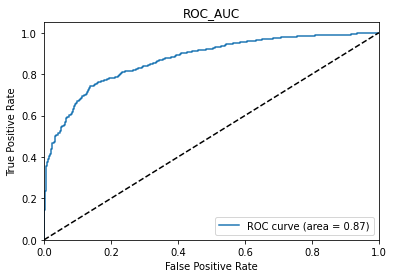

f1_score = 0.6596858638743455
roc_auc = 0.870950970226633
precision = 0.6
recall = 0.7325581395348837


In [236]:
calculate_metrics(cat_model_smote, X_valid, y_valid)

In [237]:
ups_cat_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,num_of_products,34.922100
1,age,21.483716
2,balance,11.100677
3,is_active_member,8.359257
4,geography_germany,5.908166
5,estimated_salary,4.505174
6,credit_score,4.244114
7,tenure,3.493532
8,gender_female,1.651872
9,gender_male,1.534714


### Random Forest sm

clf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 10],
    'max_depth': [10, 35, 2],
    'min_samples_leaf': range (1,5),
    'min_samples_split': range (1,10)}
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1', verbose=10)  
grid_search.fit(X_train, y_train)

print('Наилучшая комбинация параметров:', grid_search.best_params_)
print('f1 score =', grid_search.best_score_)

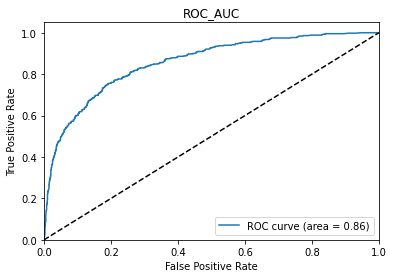

f1_score = 0.6163069544364509
roc_auc = 0.8564071989334914
precision = 0.6361386138613861
recall = 0.5976744186046512


In [238]:
param_rf = {
    'n_estimators': 150,
    'max_depth': 30,
    'min_samples_leaf': 1,
    'min_samples_split': 3
}
model_rf_smote = RandomForestClassifier(random_state=RANDOM_STATE, **param_rf)
model_rf_smote.fit(X_res, y_res)
calculate_metrics(model_rf_smote, X_valid, y_valid)

scores = cross_val_score(model_rf_smote, X_res, y_res, cv=5, scoring='f1')
print('f1 scores:', scores)
print('f1 mean:', scores.mean())

### UPSAMPLE

In [242]:
def upsample(features,target,repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled,random_state=12345)

    return features_upsampled, target_upsampled 
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

data = np.column_stack((features_upsampled, target_upsampled))
data_shuffled = shuffle(data, random_state=RANDOM_STATE)
X_ups = data_shuffled[:, :-1]
y_ups = data_shuffled[:, -1]
X_ups = pd.DataFrame(X_ups, columns=features_train.columns)


### RF upsample

clf = RandomForestClassifier(random_state=RANDOM_STATE)
param_grid = {
    'n_estimators': [100, 200, 10],
    'max_depth': [10, 35, 2],
    'min_samples_leaf': range (1,5),
    'min_samples_split': range (1,10)}
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1', verbose=10)  
grid_search.fit(X_ups, y_ups)

print('Наилучшая комбинация параметров:', grid_search.best_params_)
print('f1 score =', grid_search.best_score_)

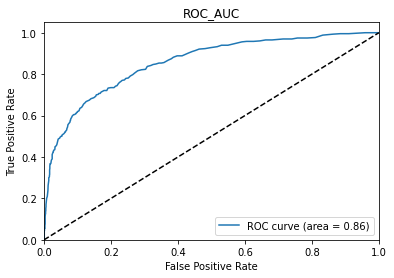

f1_score = 0.6015625
roc_auc = 0.8559724485261443
precision = 0.6834319526627219
recall = 0.5372093023255814


In [243]:
param_rf = {
    'n_estimators': 200,
    'max_depth': 25,
    'min_samples_leaf': 1,
    'min_samples_split': 2
}
model_rf_ups = RandomForestClassifier(random_state=RANDOM_STATE, **param_rf)
model_rf_ups.fit(X_ups,y_ups)
calculate_metrics(model_rf_ups, X_valid, y_valid)

### Cat upsample

cat_model = CatBoostClassifier()
cat_grid = {'learning_rate': [0.03, 0.1],
            'depth': [4, 6],
            'l2_leaf_reg': [1, 5]
           }
grid_search = GridSearchCV(cat_model, cat_grid, cv=5,scoring='f1')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

In [244]:
ups_train_data = Pool(data=X_ups,
                  label=y_ups
                     )

ups_valid_data = Pool(data=X_valid,
                  label=y_valid
                     )
ups_cat_model = CatBoostClassifier(verbose=100,learning_rate = 0.007, random_state=RANDOM_STATE,eval_metric='TotalF1')
ups_cat_model.fit(ups_train_data, eval_set = ups_valid_data,use_best_model=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7674416	test: 0.8061935	best: 0.8061935 (0)	total: 8.53ms	remaining: 8.53s
100:	learn: 0.7834003	test: 0.8068669	best: 0.8087507 (3)	total: 523ms	remaining: 4.65s
200:	learn: 0.7924824	test: 0.8117948	best: 0.8127335 (153)	total: 883ms	remaining: 3.51s
300:	learn: 0.7979532	test: 0.8119844	best: 0.8132419 (244)	total: 1.25s	remaining: 2.91s
400:	learn: 0.8041471	test: 0.8177351	best: 0.8177351 (397)	total: 1.61s	remaining: 2.4s
500:	learn: 0.8116946	test: 0.8203992	best: 0.8212606 (471)	total: 2s	remaining: 1.99s
600:	learn: 0.8183087	test: 0.8229839	best: 0.8234969 (597)	total: 2.38s	remaining: 1.58s
700:	learn: 0.8238868	test: 0.8271112	best: 0.8271112 (670)	total: 2.8s	remaining: 1.19s
800:	learn: 0.8306040	test: 0.8292708	best: 0.8297029 (793)	total: 3.15s	remaining: 783ms
900:	learn: 0.8345291	test: 0.8291887	best: 0.8297029 (793)	total: 3.54s	remaining: 389ms
999:	learn: 0.8370076	test: 0.8290226	best: 0.8297029 (793)	total: 4.01s	remaining: 0us

bestTest = 0.82970285

scores_cat = cross_val_score(ups_cat_model, X_ups, y_ups, cv=5, scoring='f1')
print('f1 scores:', scores_cat)
print('f1 mean:', scores_cat.mean())


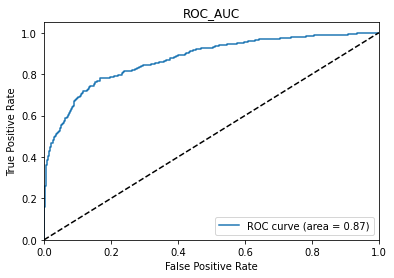

f1_score = 0.6504854368932039
roc_auc = 0.873306176862687
precision = 0.5583333333333333
recall = 0.7790697674418605


In [245]:
calculate_metrics(ups_cat_model, X_valid, y_valid)

In [246]:
cat_metrics_params = {'catboost': ['upsampling', 'smote'],
        'learning_rate': [0.007, 0.003],
        'roc_auc': [0.87, 0.87],
        'f1_score': [0.62, 0.65],
        'precision': [0.52, 0.59],
        'recall': [0.78, 0.74]}

cat_metrics_params = pd.DataFrame(cat_metrics_params)
cat_metrics_params

,catboost,learning_rate,roc_auc,f1_score,precision,recall
0,upsampling,0.007,0.87,0.62,0.52,0.78
1,smote,0.003,0.87,0.65,0.59,0.74


In [247]:
rf_metrics_params = {'random_forest': ['upsampling', 'smote'],
        'n_estimators': [150, 200],
        'max_depth': [30, 25],
        'min_samples_leaf': [1, 1],
        'min_samples_split': [2, 3],
        'f1_score': [0.61, 0.61],
        'precision': [0.67, 0.62],
        'recall': [0.56, 0.6],
        'roc_auc': [0.85, 0.86]}

rf_metrics_params = pd.DataFrame(rf_metrics_params)
rf_metrics_params

,random_forest,n_estimators,max_depth,min_samples_leaf,min_samples_split,f1_score,precision,recall,roc_auc
0,upsampling,150,30,1,2,0.61,0.67,0.56,0.85
1,smote,200,25,1,3,0.61,0.62,0.60,0.86


### Вывод 


- Для балансировки был выбран алгоритм создания синтетических данных SMOTE и метод UPSAMPLE


- Catboost и Random forest показали стабильные высокие метрики


- Оба алгоритма дали более высокий предикт при использовании метода балансировки классов upsample


## Тестирование модели

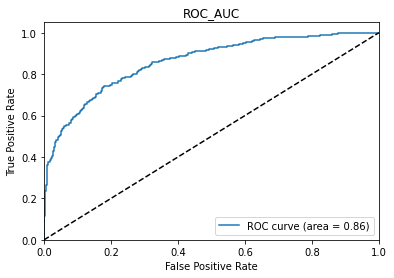

f1_score = 0.5928270042194093
roc_auc = 0.8598408057179987
precision = 0.49471830985915494
recall = 0.7394736842105263


In [248]:
calculate_metrics(ups_cat_model, X_test, y_test)

In [249]:
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(features_train, target_train)
dummy_predictions = dummy_model.predict(features_train)

dummy_accuracy = f1_score(target_train, dummy_predictions)
pred_rf = ups_cat_model.predict(features_valid)
cat_f1 = f1_score(pred_rf, target_valid)
if cat_f1 > dummy_accuracy:
    print("Модель адекватна")
else:
    print("Модель не адекватна")

Модель адекватна


In [250]:
ups_cat_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,num_of_products,34.922100
1,age,21.483716
2,balance,11.100677
3,is_active_member,8.359257
4,geography_germany,5.908166
5,estimated_salary,4.505174
6,credit_score,4.244114
7,tenure,3.493532
8,gender_female,1.651872
9,gender_male,1.534714


### Вывод 


- Балансировка с помощью upsample значительно увеличила результаты модели


- Значение `roc_auc` - это площадь под кривой ROC, которая показывает зависимость между долей верно классифицированных положительных примеров и долей ложно-положительных примеров при изменении порога бинарной классификации. Чем ближе значение `roc_auc` к 1, тем лучше качество модели. В нашем случае значение `roc_auc` равно 0.872, что говорит о том, что модель имеет хорошее качество классификации.


- Модель проверена на адекватность с помощью DummyClassifier